메켑

In [81]:
# !pip install konlpy

In [82]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
from soynlp.normalizer import repeat_normalize
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

#필요없는 경고무시
import warnings
warnings.filterwarnings('ignore')

#시각화용 임포트 모음
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go

In [83]:
#1. Naver Sentiment Movie Corpus v1.0 다운로드
train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')

#파일을 이진모드로 읽어온다. 디코드는 utf8로한다.
train_text = open(train_file,'rb').read().decode(encoding='utf-8')

#테스트용
# test_file = tf.keras.utils.get_file( 'test.txt','https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')
# test_text = open(test_file,'rb').read().decode(encoding='utf-8')


df_train = pd.DataFrame({
    'text':[ row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t')>0 ],
    'sentiment': [ int(row.split('\t')[2]) for row in train_text.split('\n')[1:] if row.count('\t')>0]
})

# 데이터 크기 지정
df_train = df_train[::5]

#널값있는지 확인
empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

#널값제거
#빈 문자열을 NaN 값으로 대체
df_train[{'text','sentiment'}].replace('', np.nan, inplace=True)

# NaN 값을 포함하는 행 제거
df_train.dropna( inplace=True)

print(df_train)


빈 문자열이 없습니다.
                                                 text  sentiment
0                                 아 더빙.. 진짜 짜증나네요 목소리          0
5       막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.          0
10                                   걍인피니트가짱이다.진짜짱이다♥          1
15                                   ㄱ냥 매번 긴장되고 재밋음ㅠㅠ          1
20          나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님          1
...                                               ...        ...
149975                               무지 자극적 에로틱 드라마!!          1
149980         아, 진짜 웃긴다...프랑스 영화 정말 싫어했었는데 이 영화는 열외~          1
149985                    해석하기 나름인 패륜영화. 그래도 이건 아니잖니.          0
149990                                   이걸 영화라고 찎었냐?          0
149995                            인간이 문제지.. 소는 뭔죄인가..          0

[30000 rows x 2 columns]


In [84]:
# train 데이터 입력값(X)을 정제(Cleaning)
def clean_korean_text(text):
    # 특수 문자 및 숫자 제거
    text = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s]', ' ', text)
    # 반복되는 자음, 모음 제거 (e.g., 'ㅋㅋㅋ' -> 'ㅋ')
    text = repeat_normalize(text, num_repeats=1)
    # 띄어쓰기 정규화 (연속된 공백 문자를 하나의 공백 문자로 변환)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df_train['text']=df_train['text'].apply(lambda x:clean_korean_text(x))
df_train

,text,sentiment
0,아 더빙 진짜 짜증나네요 목소리,0
5,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화 ㅋㅋㅋ 별반개도 아까움,0
10,걍인피니트가짱이다 진짜짱이다,1
15,ㄱ냥 매번 긴장되고 재밋음ㅠㅠ,1
20,나름 심오한 뜻도 있는 듯 그냥 학생이 선생과 놀아나는 영화는 절대 아님,1
...,...,...
149975,무지 자극적 에로틱 드라마,1
149980,아 진짜 웃긴다 프랑스 영화 정말 싫어했었는데 이 영화는 열외,1
149985,해석하기 나름인 패륜영화 그래도 이건 아니잖니,0
149990,이걸 영화라고 찎었냐,0


In [85]:
#빈문자열 존재 확인
empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

빈 문자열이 존재합니다.


In [86]:
#빈문자열제거
df_train.drop(df_train[df_train['text'] == ""].index, inplace=True)

empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))
if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

빈 문자열이 없습니다.


In [87]:
#정제된 텍스트를 mecab토큰화한다 ,여기서는 임시로 Okt
from konlpy.tag import Mecab
mecab=Mecab(dicpath=r'C:\mecab\mecab-ko-dic')
df_train['text']=df_train['text'].apply(lambda x: mecab.morphs(x))
df_train

,text,sentiment
0,"[아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]",0
5,"[막, 걸음마, 뗀, 세, 부터, 초등, 학교, 학년, 생, 인, 살용, 영화, ㅋ...",0
10,"[걍인피니트가짱이다, 진짜, 짱, 이, 다]",1
15,"[ㄱ, 냥, 매번, 긴장, 되, 고, 재, 밋, 음, ㅠㅠ]",1
20,"[나름, 심오, 한, 뜻, 도, 있, 는, 듯, 그냥, 학생, 이, 선생, 과, 놀...",1
...,...,...
149975,"[무지, 자극, 적, 에로, 틱, 드라마]",1
149980,"[아, 진짜, 웃긴다, 프랑스, 영화, 정말, 싫, 어, 했었, 는데, 이, 영화,...",1
149985,"[해석, 하, 기, 나름, 인, 패, 륜, 영화, 그래도, 이건, 아니, 잖니]",0
149990,"[이걸, 영화, 라고, 찎었냐]",0


In [88]:
#불용어 사전불러오기
stopwords = open('./stopwords.txt','rb').read().decode(encoding='utf-8').split('\r\n')
stopwords

['가',
 '가까스로',
 '가령',
 '각',
 '각각',
 '각자',
 '각종',
 '갖고말하자면',
 '같다',
 '같이',
 '개의치않고',
 '거니와',
 '거바',
 '거의',
 '것',
 '것과 같이',
 '것들',
 '게다가',
 '게우다',
 '겨우',
 '견지에서',
 '결과에 이르다',
 '결국',
 '결론을 낼 수 있다',
 '겸사겸사',
 '고려하면',
 '고로',
 '곧',
 '공동으로',
 '과',
 '과연',
 '관계가 있다',
 '관계없이',
 '관련이 있다',
 '관하여',
 '관한',
 '관해서는',
 '구',
 '구체적으로',
 '구토하다',
 '그',
 '그들',
 '그때',
 '그래',
 '그래도',
 '그래서',
 '그러나',
 '그러니',
 '그러니까',
 '그러면',
 '그러므로',
 '그러한즉',
 '그런 까닭에',
 '그런데',
 '그런즉',
 '그럼',
 '그럼에도 불구하고',
 '그렇게 함으로써',
 '그렇지',
 '그렇지 않다면',
 '그렇지 않으면',
 '그렇지만',
 '그렇지않으면',
 '그리고',
 '그리하여',
 '그만이다',
 '그에 따르는',
 '그위에',
 '그저',
 '그중에서',
 '그치지 않다',
 '근거로',
 '근거하여',
 '기대여',
 '기점으로',
 '기준으로',
 '기타',
 '까닭으로',
 '까악',
 '까지',
 '까지 미치다',
 '까지도',
 '꽈당',
 '끙끙',
 '끼익',
 '나',
 '나머지는',
 '남들',
 '남짓',
 '너',
 '너희',
 '너희들',
 '네',
 '넷',
 '년',
 '논하지 않다',
 '놀라다',
 '누가 알겠는가',
 '누구',
 '다른',
 '다른 방면으로',
 '다만',
 '다섯',
 '다소',
 '다수',
 '다시 말하자면',
 '다시말하면',
 '다음',
 '다음에',
 '다음으로',
 '단지',
 '답다',
 '당신',
 '당장',
 '대로 하다',
 '대하면',
 '대하여',
 '대해 말하자면',
 '대해서',
 '댕그',


In [89]:
#불용어 제거 적용
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x if word not in stopwords]).split() )
df_train

,text,sentiment
0,"[더, 빙, 진짜, 짜증, 네요, 목소리]",0
5,"[막, 걸음마, 뗀, 세, 초등, 학교, 학년, 생, 인, 살용, ㅋㅋㅋ, 별반, ...",0
10,"[걍인피니트가짱이다, 진짜, 짱]",1
15,"[ㄱ, 냥, 긴장, 되, 재, 밋, 음, ㅠㅠ]",1
20,"[나름, 심오, 한, 뜻, 있, 듯, 그냥, 학생, 선생, 놀아나, 절대, 아님]",1
...,...,...
149975,"[무지, 자극, 적, 에로, 틱, 드라마]",1
149980,"[진짜, 웃긴다, 프랑스, 정말, 싫, 했었, 는데, 열외]",1
149985,"[해석, 기, 나름, 인, 패, 륜, 이건, 잖니]",0
149990,"[이걸, 라고, 찎었냐]",0


In [90]:
#토큰화된걸 ' ' 공백한칸을 기준으로 다시 합쳐준다.
df_train['text']=df_train['text'].apply(lambda x: ' '.join(i for i in x) )
df_train
#==> 교착어의 단점을 보완해준것이다.

,text,sentiment
0,더 빙 진짜 짜증 네요 목소리,0
5,막 걸음마 뗀 세 초등 학교 학년 생 인 살용 ㅋㅋㅋ 별반 개 아까움,0
10,걍인피니트가짱이다 진짜 짱,1
15,ㄱ 냥 긴장 되 재 밋 음 ㅠㅠ,1
20,나름 심오 한 뜻 있 듯 그냥 학생 선생 놀아나 절대 아님,1
...,...,...
149975,무지 자극 적 에로 틱 드라마,1
149980,진짜 웃긴다 프랑스 정말 싫 했었 는데 열외,1
149985,해석 기 나름 인 패 륜 이건 잖니,0
149990,이걸 라고 찎었냐,0


In [74]:
df_train['text'].str.len().quantile(0.9)

89.0

리뷰의 최대 길이 : 226
리뷰의 평균 길이 : 40.8558809699738
리뷰의 90%를 포함하는 길이 : 89.0


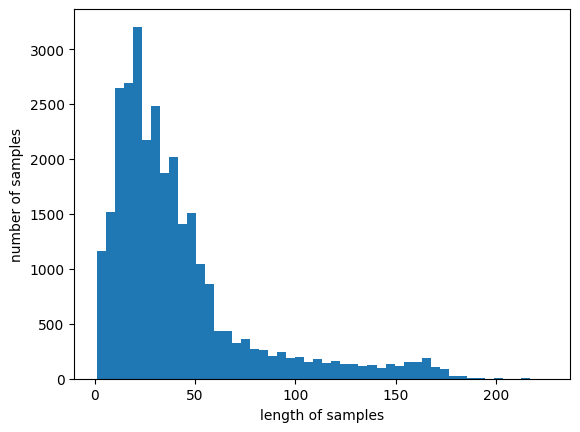

In [75]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in df_train['text']))
print('리뷰의 평균 길이 :',sum(map(len, df_train['text']))/len(df_train['text']))
print('리뷰의 90%를 포함하는 길이 :', df_train['text'].str.len().quantile(0.9) )
plt.hist([len(review) for review in df_train['text']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 리뷰의 90%를 포함하는 길이
max_length = df_train['text'].str.len().quantile(0.9)

#긴 리뷰와 길이1 문자열을 삭제
df_filtered = df_train[(df_train['text'].str.len() >= 2) & (df_train['text'].str.len() <= max_length)]

In [76]:
#리뷰의 총개수
df_train['text'].count()

29774

In [77]:
#tfidf 벡터화 적용
vectorizer=TfidfVectorizer( )
x = vectorizer.fit_transform(df_train['text'])
y = df_train['sentiment']

# vectorizer 객체를 저장 => 입력되는 문자도 똑같이 벡터화해줌
# with open('test2_nofunc_vectorizer.pkl', 'wb') as f:
#     pickle.dump(vectorizer, f)


#희소행렬을 밀집행렬로 바꾸어준다. 문제점: 차원이 너무 커져서 많은 데이터를 학습시킬수없다.
x_train_dense = np.expand_dims( x.toarray(), axis=-1 )

In [78]:
#DNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization , Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [80]:
model = Sequential([
    # input_layer,
    Input(shape=(x_train_dense.shape[1],)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일 및 학습
optimizer= Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 콜백 정의
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# model.fit(X.toarray(), y, epochs = 10, batch_size = 500, validation_split=0.2)  #0.8417
model.fit(
    x.toarray(), y, 
    epochs = 20, batch_size = 162, 
    validation_split=0.3,
    callbacks=[early_stopping]
    ) 

#Okt()토크나이저를 넣지 않았을 때
# loss: 0.1659 - accuracy: 0.9387 - val_loss: 0.5841 - val_accuracy: 0.7403
#okt() 토크나이저를 썼을 때
# loss: 0.1598 - accuracy: 0.9409 - val_loss: 0.5469 - val_accuracy: 0.8003
# okt() 토크나이저를 벡터나이저와 분리해서 썼을때
# loss: 0.3933 - accuracy: 0.8238 - val_loss: 0.4327 - val_accuracy: 0.7944


Epoch 1/20
129/129 [==============================] - 14s 83ms/step - loss: 0.4968 - accuracy: 0.7460 - val_loss: 0.6471 - val_accuracy: 0.7490
Epoch 2/20
129/129 [==============================] - 9s 67ms/step - loss: 0.3218 - accuracy: 0.8611 - val_loss: 0.5984 - val_accuracy: 0.7792
Epoch 3/20
129/129 [==============================] - 8s 60ms/step - loss: 0.2377 - accuracy: 0.9026 - val_loss: 0.5220 - val_accuracy: 0.7740
Epoch 4/20
129/129 [==============================] - 8s 61ms/step - loss: 0.1832 - accuracy: 0.9260 - val_loss: 0.4667 - val_accuracy: 0.7748
Epoch 5/20
129/129 [==============================] - 9s 71ms/step - loss: 0.1525 - accuracy: 0.9409 - val_loss: 0.5059 - val_accuracy: 0.7668
Epoch 6/20
129/129 [==============================] - 10s 76ms/step - loss: 0.1315 - accuracy: 0.9468 - val_loss: 0.5823 - val_accuracy: 0.7632
Epoch 7/20
129/129 [==============================] - 10s 75ms/step - loss: 0.1148 - accuracy: 0.9551 - val_loss: 0.6548 - val_accuracy: 0.7

In [22]:
# model.save('4_6_DNN 토큰화수정.h5')

# 서비스단 테스트

In [ ]:
#모델 불러오기
# from tensorflow.keras.models import load_model
# loaded_model= load_model('./4_6_DNN 토큰화수정.h5')

In [ ]:
#저장된 vectorizer 불러오기
# import pickle
# with open('./test2_nofunc_vectorizer.pkl', 'rb') as f:
#     loaded_test_vectorizer = pickle.load(f)

In [23]:
test_texts = ['노잼임 이런거 할바에 딴거함']

#문자열이 아닌게 있는지 확인
for i in test_texts:
    if type(i)!=str:
        print(i)
        
# train 데이터 입력값(X)을 정제(Cleaning)
import re
from soynlp.normalizer import repeat_normalize

def clean_korean_text(text):
    # 특수 문자 및 숫자 제거
    text = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s]', '', text)

    # 반복되는 자음, 모음 제거 (e.g., 'ㅋㅋㅋ' -> 'ㅋ')
    text = repeat_normalize(text, num_repeats=1)

    # 띄어쓰기 정규화 (연속된 공백 문자를 하나의 공백 문자로 변환)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

clean_test_texts=[]
for i in test_texts:
    clean_test_texts.append(clean_korean_text(i))

#정제된 텍스트를 벡터화하기전에 토큰화한다
from konlpy.tag import Okt
tokenized_clean_test_texts =[ Okt().morphs(i) for i in clean_test_texts ]


#이미 토큰화된걸 ' ' 공백한칸을 기준으로 다시 합쳐준다.
rejoined_tokenized_test_texts = [' '.join(i) for i in tokenized_clean_test_texts]

    
# 학습된 TF-IDF 벡터라이저로 테스트 데이터 변환
X_test_sample = vectorizer.transform(rejoined_tokenized_test_texts)
X_test_sample_dense = X_test_sample.toarray()

# 모델을 사용하여 예측 수행
predictions = model.predict(X_test_sample_dense)
print(predictions)

# 예측 결과 출력 (긍정: 1, 부정: 0)
print("예측 결과:", np.round( predictions ).astype(int))

1/1 [==============================] - 0s 295ms/step
[[0.01945549]]
예측 결과: [[0]]


# 카톡대화서비스 테스트

In [24]:
# 카톡대화 불러와서 정제,(정규화코드)하는 함수
import re

def get_from_txt(txt):
    data= open(txt,"r", encoding='utf-8').read().split('\n')
    sentences=[]
    for line in data:
        pattern = r'\[(.*?)\]\s+\[(.*?)\]\s+(.+)'
        match = re.match(pattern, line)
        if match:
            name = match.group(1)  # 첫 번째 대괄호 안의 단어 추출
            time = match.group(2)  # 두 번째 대괄호 안의 단어 추출
            content = match.group(3)  # 대괄호 뒤의 내용 추출
            # print(name, time, content)
            temp=[name,time,content]
            sentences.append(temp)    
    return sentences

#함수확인
get_from_txt('sample.txt')

[['김찬란', '오후 10:01', '사진'],
 ['김찬란', '오후 9:38', 'https://youtube.com/watch?v=o1G7DWFFHso&feature=share'],
 ['김찬란', '오후 10:42', '사진'],
 ['김찬란', '오후 10:42', '사기치고다니는 한장규'],
 ['김하영', '오후 10:45', '이야'],
 ['김하영', '오후 10:46', '게임에서도 치네'],
 ['김찬란', '오후 10:46', '진짜 니말이 맞다 진짜 친구면 친구한테 민폐되기 싫어서 돈빌려달란 소리도 안한다'],
 ['김하영', '오전 12:25', '이모티콘'],
 ['김하영', '오전 12:35', '회식끝나고 집가는중'],
 ['김찬란', '오전 12:35', '음음 초밥집 회식은 어디서 하냐'],
 ['김하영', '오전 12:35', '우리 실장형네 직이 고기집해서 글로갔다'],
 ['김하영', '오전 12:36', '회식하면 맨날 돼지고기만 먹는다'],
 ['김찬란', '오전 12:36', 'ㅋㅋㅋㅋㅋㅋ케'],
 ['김하영', '오전 12:36', '이모티콘'],
 ['김찬란', '오전 12:36', '아 내수용 회식'],
 ['김찬란', '오전 12:36', '사진'],
 ['김하영', '오전 12:36', 'ㅋㅋㅋㅋ 그런거 아니고 애들이 여기가 맛있다고 여기서먹음'],
 ['김찬란', '오전 12:37', '고기 얘시하니까'],
 ['김찬란', '오전 12:37', '나도 고기가 먹고 싶군'],
 ['김하영', '오전 12:37', 'ㅋㅋㅋㅋ '],
 ['김찬란', '오전 12:37', '낼 사먹어야겠다'],
 ['김하영', '오전 12:37', '와라 엉아가 소고기 사줄께'],
 ['김찬란', '오전 12:37', '내가 사야지 씹새야 입벌려'],
 ['김찬란', '오전 12:37', '고기 들어간'],
 ['김찬란', '오전 12:38', '너는 내가 사주고 싶으니까 '],
 ['김찬란', '오전 12:38', '취직해서

In [25]:
#닉네임 입력단 
target_name = str(input())
print(target_name)  #김하영 입력

김하영


In [27]:
# 저장된 모델 불러오기
# from tensorflow.keras.models import load_models
# model= load_models('4_6_DNN 토큰화수정.h5')


#입력된 이름의 '대화내역만' 담기
received_texts= []
for i in get_from_txt('sample.txt'): 
    if i[0] == target_name:
        received_texts.append( i[2] )
        
# 이모티콘, 사진, 샵검색 제거 
clean_received_texts2 = []
for i in received_texts:
    if '샵검색:' not in i: 
        if "이모티콘" not in i:
            if '샵검색:' not in i:
                clean_received_texts2.append(str(i))

#=========== 이쯤에서 답장시간 계산기 구현   =======================
          
          
#텍스트 정제  
clean_received_texts2= [clean_korean_text(i) for i in clean_received_texts2]



#정제된 텍스트를 벡터화하기전에 토큰화한다
from konlpy.tag import Okt
tokenized_clean_test_texts2 =[ Okt().morphs(i) for i in clean_received_texts2 ]

#이미 토큰화된걸 ' ' 공백한칸을 기준으로 다시 합쳐준다.
rejoined_tokenized_test_texts2 = [' '.join(i) for i in tokenized_clean_test_texts2]


# # 학습된 TF-IDF 벡터라이저로 테스트 데이터 변환
X_received_texts = vectorizer.transform(rejoined_tokenized_test_texts2)
X_received_texts_dense = X_received_texts.toarray()


# # 모델을 사용하여 예측 수행
predictions = np.round(model.predict(X_received_texts_dense))
#예측 결과 출력 (긍정: 1, 부정: 0)
print(predictions.squeeze().tolist()) #차원을 축소하고 리스트객체로 변환

cnt0=0;cnt1=0
for i in predictions.squeeze().tolist():
    if int(i)==0:
        cnt0+=1
    else:
        cnt1+=1

#부정과 긍정문의 갯수
print('부정문과 긍정문의 갯수:',cnt0,cnt1)

#긍정과 부정의 비율( 긍정문의 수 / 부정문의 수)
print('긍정과 부정의 비율: ',cnt1/cnt0)
#숫자가 1이상이고 높을수록 긍정적이다.



6/6 [==============================] - 0s 7ms/step
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
부정문과 긍정문의 갯수: 78 97
긍정과 부정의 비율:  1.2435897435897436
